In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sklearn
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

In [2]:
# Settings
k_folds = 5

In [3]:
xls = pd.ExcelFile('Dataset - LBP RA.xlsx')
dataframe = pd.read_excel(xls, 'Training Dataset')
#dataframe = dataframe[(dataframe["Treatment"] == 1) | (dataframe["Treatment"] == 5)]
dataframe = dataframe[(dataframe["Treatment"] != 5)]
dataframe_original = dataframe.copy(True)
print(dataframe.info())

<class 'pandas.core.frame.DataFrame'>
Index: 897 entries, 0 to 1545
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Treatment                         897 non-null    int64  
 1   Fever                             879 non-null    float64
 2   Duration_of_pain                  877 non-null    float64
 3   Sick_leave                        897 non-null    int64  
 4   Earlier_hospitalization           897 non-null    int64  
 5   Workoverload                      255 non-null    float64
 6   Familiy_history                   897 non-null    int64  
 7   Depression                        897 non-null    int64  
 8   Extremely_nervous                 862 non-null    float64
 9   Stress                            897 non-null    int64  
 10  Relationship_with_colleagues      581 non-null    float64
 11  Irrational_thoughts_risk_lasting  857 non-null    float64
 12  Irrational_t

In [4]:
categorical_columns = ["Treatment", "Weightloss_per_year"]

boolean_columns = [
    "Fever",
    "Sick_leave",
    "Earlier_hospitalization",
    "Workoverload",
    "Familiy_history",
    "Depression",
    "Stress",
    "Uses_analgesics",
    "Uses_corticosteroids",
    "Serious_disease",
    "Neurogenic_signals",
    "Continuous_pain",
    "Nocturnal_pain",
    "Loss_muscle_strength",
    "Trauma",
    "Failure_symptoms",
    "Incoordination",
    "Paidwork",
]

ordinal_columns = [
    "Duration_of_pain",
    "Extremely_nervous",
    "Relationship_with_colleagues",
    "Irrational_thoughts_risk_lasting",
    "Irrational_thoughts_work",
    "Coping_strategy",
    "Kinesiophobia_physical_exercise",
    "Kinesiophobia_pain_stop",
    "Age",
    "neck_pain_intensity",
    "low_back_pain_intensity",
    "arm_left_pain_intensity",
    "arm_right_pain_intensity",
    "leg_left_pain_intensity",
    "leg_right_pain_intensity",
    "working_ability",
]

value_columns = ["Decreased_mobility"]

In [5]:
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(dataframe)
imputed_data = imputer.transform(dataframe)
dataframe = pd.DataFrame(imputed_data, columns=dataframe.columns)

# Mapping column types
dataframe[value_columns] = dataframe[value_columns].astype("Int64")
dataframe[categorical_columns] = dataframe[categorical_columns].astype("category")
dataframe[boolean_columns] = dataframe[boolean_columns].astype("boolean")

# Mapping 
age_mapping = {
    "0-19": 0,
    "20-29": 1,
    "30-39": 2,
    "40-49": 3,
    "50-59": 4,
    "60-69": 5,
    "70-79": 6,
    ">=80": 7,
}

dataframe["Age"] = dataframe["Age"].replace(age_mapping)

for column in ordinal_columns:
    dataframe[[column]] = dataframe[[column]].astype("Int64")
    dataframe[column] = pd.Categorical(dataframe[column], categories=sorted(dataframe[column].unique()), ordered=True)

In [6]:
# Filter columns
missing_percentages = dataframe_original.isnull().mean()
columns_to_remove = missing_percentages[missing_percentages > 0.7].index.tolist()
dataframe = dataframe.drop(columns=columns_to_remove)

categorical_columns = [
    col for col in categorical_columns if col not in columns_to_remove
]
ordinal_columns = [col for col in ordinal_columns if col not in columns_to_remove]
boolean_columns = [col for col in boolean_columns if col not in columns_to_remove]
value_columns = [col for col in value_columns if col not in columns_to_remove]

In [7]:
# Duplicate data (duplication is only used for training and overrepresenting minority data)
X = dataframe.drop(columns=["Treatment"])
y = dataframe["Treatment"]

minority_data = dataframe[(dataframe["Treatment"] != 1) & (dataframe["Treatment"] != 5)]
minority_data = pd.concat([minority_data] * 3)
minority_X = minority_data.drop(columns=["Treatment"])
minority_y = minority_data["Treatment"]
train_X = pd.concat([minority_X, X], axis=0)
train_y = pd.concat([minority_y, y], axis=0)

In [8]:
print("Number of rows for each unique value of the Treatment column:")
print(dataframe["Treatment"].value_counts())

combined_train = pd.concat([train_X, train_y], axis=1)
print("Number of rows for each unique value of the Treatment column in the combined dataset:")
print(combined_train["Treatment"].value_counts())

Number of rows for each unique value of the Treatment column:
Treatment
1    659
2    160
3     65
4     13
Name: count, dtype: int64
Number of rows for each unique value of the Treatment column in the combined dataset:
Treatment
1    659
2    640
3    260
4     52
Name: count, dtype: int64


In [9]:
feature_selector = SelectKBest(score_func=f_classif, k=15)
selected_features = feature_selector.fit_transform(train_X, train_y)
selected_feature_indices = feature_selector.get_support(indices=True)
remaining_features = train_X.columns[~selected_feature_indices]

boolean_columns = [col for col in boolean_columns if col in remaining_features]
categorical_columns = [col for col in categorical_columns if col in remaining_features]
ordinal_columns = [col for col in ordinal_columns if col in remaining_features]
value_columns = [col for col in value_columns if col in remaining_features]

train_X = train_X[remaining_features]

print("Remaining Features:")
print(remaining_features)

Remaining Features:
Index(['Paidwork', 'leg_right_pain_intensity', 'Incoordination', 'Trauma',
       'Nocturnal_pain', 'Decreased_mobility', 'Continuous_pain',
       'Neurogenic_signals', 'Serious_disease', 'Uses_corticosteroids',
       'Kinesiophobia_pain_stop', 'Stress', 'Earlier_hospitalization',
       'Sick_leave', 'Fever'],
      dtype='object')


In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        (
            "bool",
            "passthrough",
            boolean_columns,
        ),
        (
            "cat",
            OneHotEncoder(),
            categorical_columns,
        ),
        (
            "ord",
            OrdinalEncoder(),
            ordinal_columns,
        ),
        (
            "num",
            StandardScaler(),
            value_columns,
        ),
    ]
)

# Decision Tree
param_grid_tree = {
    "tree__max_depth": [2, 3, 5, 10],
    "tree__min_samples_split": [2, 5, 10],
    "tree__min_samples_leaf": [1, 2, 4],
}
pipeline_tree = Pipeline(
    steps=[("preprocessor", preprocessor), ("tree", DecisionTreeClassifier())]
)
grid_search_tree = GridSearchCV(
    pipeline_tree, param_grid_tree, cv=k_folds, scoring="accuracy"
)
grid_search_tree.fit(train_X, train_y)
print("Fitted Decicion tree")

# Random Forest
param_grid_random_forest = {
    "rf__n_estimators": [50, 100, 200],
    "rf__max_depth": [None, 3, 5, 10, 20],
}

pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("rf", RandomForestClassifier())]
)
grid_search_random_forest = GridSearchCV(
    pipeline, param_grid_random_forest, cv=k_folds, scoring="accuracy"
)
grid_search_random_forest.fit(train_X, train_y)
print("Fitted Random Forest")

# Gradient Boosting
param_grid_gradient_boosting = {
    "estimator__learning_rate": [0.01, 0.1, 0.5],
}
pipeline_gradient_boosting = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("estimator", HistGradientBoostingClassifier()),
    ]
)
grid_search_gradient_boosting = GridSearchCV(
    pipeline_gradient_boosting,
    param_grid_gradient_boosting,
    cv=k_folds,
    scoring="accuracy",
)
grid_search_gradient_boosting.fit(train_X, train_y)
print("Fitted Gradient Boosting")

# K-Nearest Neighbors
param_grid_knn = {"knn__n_neighbors": [1, 2, 3, 5, 10, 20]}
pipeline_knn = Pipeline(
    steps=[("preprocessor", preprocessor), ("knn", KNeighborsClassifier())]
)
grid_search_knn = GridSearchCV(
    pipeline_knn, param_grid_knn, cv=k_folds, scoring="accuracy"
)
grid_search_knn.fit(train_X, train_y)
print("Fitted K-Nearest Neighbors")

# Logistic Regression
param_grid_logistic_regression = {
    "logistic_regression__C": [0.1, 1.0, 10.0],
    "logistic_regression__penalty": ["l1", "l2"],
}
pipeline_logistic_regression = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("logistic_regression", LogisticRegression(max_iter=2000, solver="saga")),
    ]
)
grid_search_logistic_regression = GridSearchCV(
    pipeline_logistic_regression,
    param_grid_logistic_regression,
    cv=k_folds,
    scoring="accuracy",
)
grid_search_logistic_regression.fit(train_X, train_y)
print("Fitted Logistic Regression")

# Neural Network
param_grid_neural_network = {
    "neural_network__hidden_layer_sizes": [(20,), (20, 20), (10, 20, 10)],
    "neural_network__alpha": [0.0001, 0.001, 0.01],
}
pipeline_neural_network = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("neural_network", MLPClassifier(max_iter=2000)),
    ]
)
grid_search_neural_network = GridSearchCV(
    pipeline_neural_network, param_grid_neural_network, cv=k_folds, scoring="accuracy"
)
grid_search_neural_network.fit(train_X, train_y)
print("Fitted Neural Network")

# SVM
param_grid_svm = {"svm__kernel": ["linear", "rbf", "poly"]}
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("svm", SVC())])
grid_search_svm = GridSearchCV(pipeline, param_grid_svm, cv=k_folds, scoring="accuracy")
grid_search_svm.fit(train_X, train_y)
print("Fitted SVM")

Fitted Decicion tree
Fitted Random Forest
Fitted Gradient Boosting
Fitted K-Nearest Neighbors
Fitted Logistic Regression
Fitted Neural Network
Fitted SVM


In [11]:
models = [
    ("Decision Tree", grid_search_tree.best_estimator_),
    ("Random Forest", grid_search_random_forest.best_estimator_),
    ("Gradient Boosting", grid_search_gradient_boosting.best_estimator_),
    ("KNN", grid_search_knn.best_estimator_),
    ("Logistic Regression", grid_search_logistic_regression.best_estimator_),
    ("Neural Network", grid_search_neural_network.best_estimator_),
    ("SVM", grid_search_svm.best_estimator_),
]

model_scores = {}
confusion_matrices = {}

for name, model in models:
    accuracy_scores = cross_val_score(model, X, y, cv=k_folds, scoring="accuracy")
    f1_scores = cross_val_score(model, X, y, cv=k_folds, scoring="f1_macro")

    model_scores[name] = {"accuracy": accuracy_scores, "f1_score": f1_scores}
    y_pred = cross_val_predict(model, X, y, cv=k_folds)
    cm = confusion_matrix(y, y_pred)
    cmn = cm.astype("int") / cm.sum(axis=1)[:, np.newaxis]

    confusion_matrices[name] = cmn

    print(f"{name}:")
    print(
        f"  Accuracy: {accuracy_scores.mean():.4f}"
    )
    print(f"  F1 Score: {f1_scores.mean():.4f}")


average_accuracy = np.mean([np.mean(scores["accuracy"]) for scores in model_scores.values()])
average_f1 = np.mean([np.mean(scores["f1_score"]) for scores in model_scores.values()])

print(f"Average Accuracy Across All Models: {average_accuracy:.4f}")
print(f"Average F1 Score Across All Models: {average_f1:.4f}")

ensemble_model = VotingClassifier(estimators=models, voting="hard")
accuracy_scores = cross_val_score(ensemble_model, X, y, scoring="accuracy")
f1_scores = cross_val_score(ensemble_model, X, y, scoring="f1_macro")

y_pred = cross_val_predict(ensemble_model, X, y, cv=k_folds)
cm = confusion_matrix(y, y_pred)
cmn = cm.astype("int") / cm.sum(axis=1)[:, np.newaxis]

confusion_matrices['Ensemble Model'] = cmn

print(
    f"Ensemble Model (Hard Voting):"
    f" Accuracy: {accuracy_scores.mean():.4f}"
    f" F1 Score: {f1_scores.mean():.4f}"
)

Decision Tree:
  Accuracy: 0.5388
  F1 Score: 0.2424
Random Forest:
  Accuracy: 0.6113
  F1 Score: 0.2165
Gradient Boosting:
  Accuracy: 0.5566
  F1 Score: 0.2306
KNN:
  Accuracy: 0.5388
  F1 Score: 0.2638
Logistic Regression:
  Accuracy: 0.6169
  F1 Score: 0.1921
Neural Network:
  Accuracy: 0.5555
  F1 Score: 0.2214
SVM:
  Accuracy: 0.6202
  F1 Score: 0.1883
Average Accuracy Across All Models: 0.5769
Average F1 Score Across All Models: 0.2222
Ensemble Model (Hard Voting): Accuracy: 0.6224 F1 Score: 0.2003


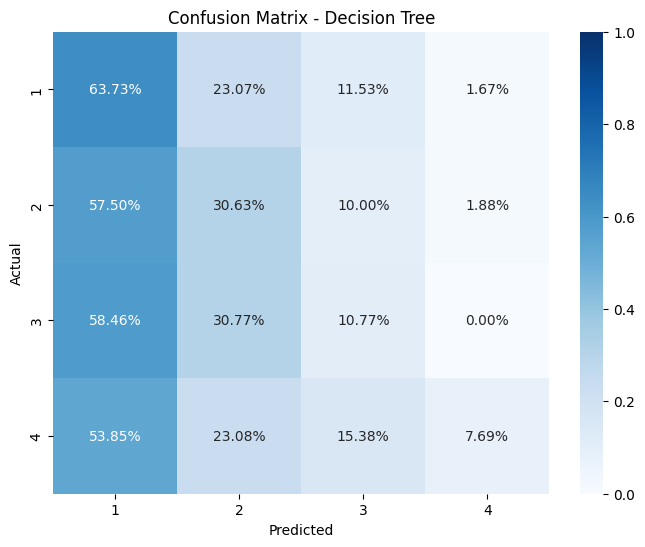

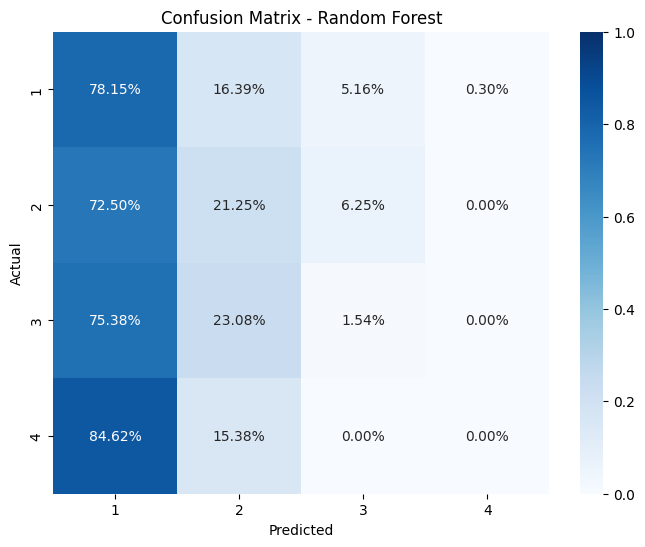

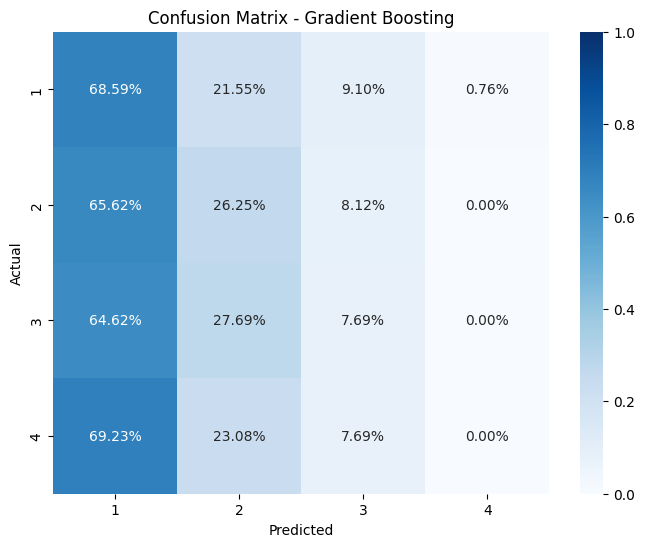

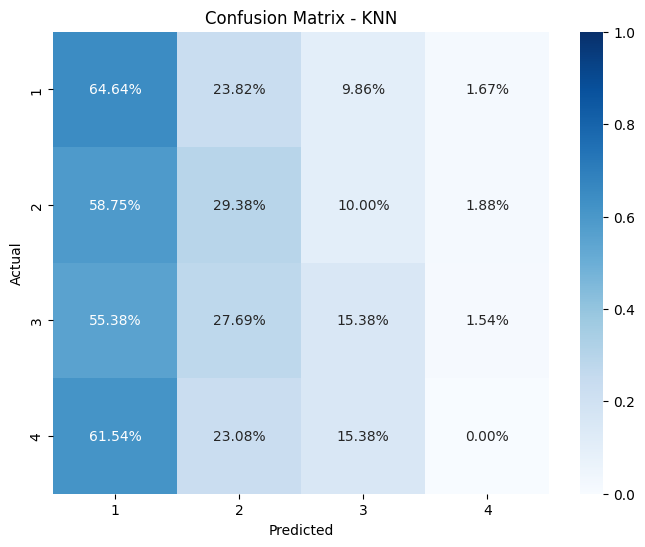

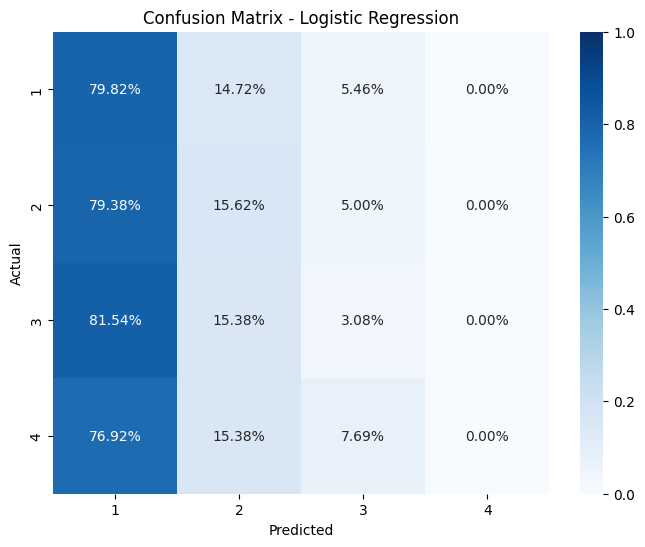

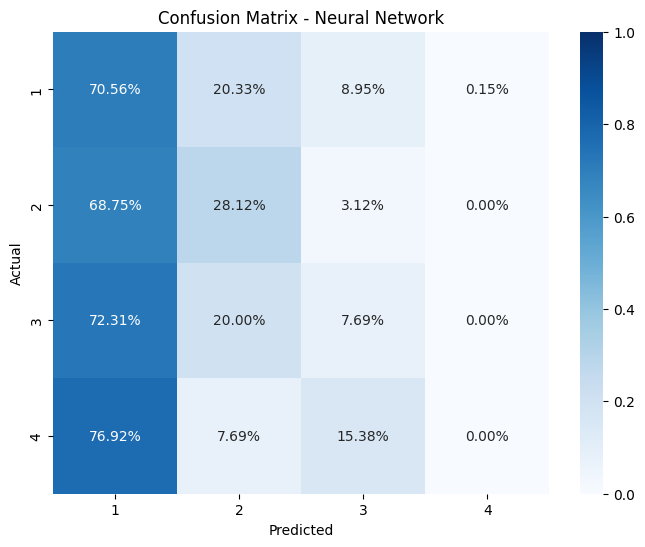

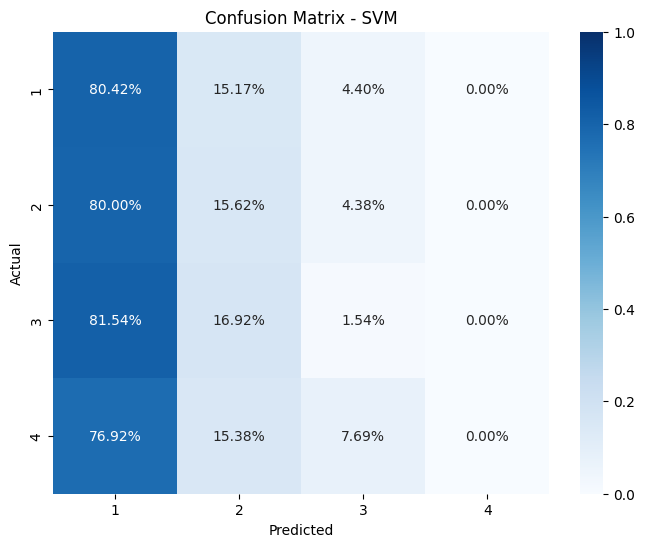

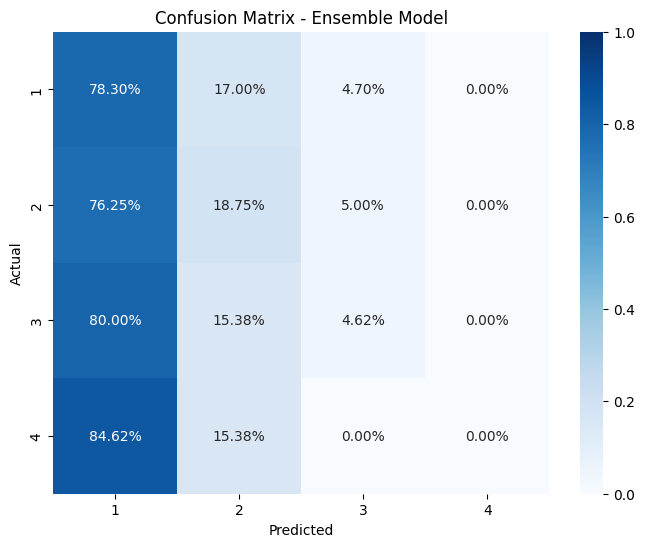

In [12]:
labels = np.unique(y)
for name, cmn in confusion_matrices.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(cmn, annot=True, cmap='Blues', fmt='.2%', xticklabels=labels, yticklabels=labels, vmin=0, vmax=1.0)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('./images/'+f'{name}.png')
    plt.show()
    